In [ ]:
# Bibliotecas
import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from joblib import Parallel, delayed
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

### Teste 1
Aplicando o método usado no HidroPrev ASAC23 com mais dados

In [2]:
dados_manaus = eda.data_processing('Cotas extraidas', '1903-01-01', '2025-05-31', ['dados_diarios_estacao_14990000.csv'])
dados_manaus

,14990000
Data,
1903-01-01,1914.0
1903-01-02,1921.0
1903-01-03,1924.0
1903-01-04,1926.0
1903-01-05,1929.0
...,...
2025-05-27,2847.0
2025-05-28,2849.0
2025-05-29,2852.0


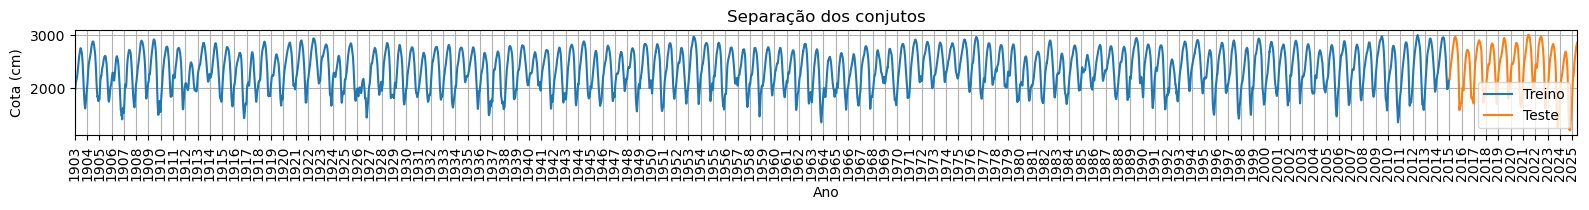

In [3]:
# Separação do conjunto
treino = dados_manaus[:'2014-12-31']
teste = dados_manaus['2015-01-01':]

plt.figure(figsize=(16, 2))
plt.plot(treino['14990000'])
plt.plot(teste['14990000'])
plt.legend(['Treino', 'Teste'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.xticks(rotation=90)
plt.xlim(dados_manaus.index[0], dados_manaus.index[-1])
plt.tight_layout()
plt.title('Separação dos conjutos')
plt.show()

In [31]:
# # Criação de batches
window_length = 365
shifts = np.arange(1,window_length+1)
# Create a dictionary of time-shifted data
x_shifts = {'lag_{}'.format(ii): treino['14990000'].shift(ii) for ii in shifts}
# Convert the shifts into a dataframe
x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)

#### MLP

In [ ]:
def run_iteration(x_shifts, treino, teste, window_length):
    mlp = MLPRegressor(hidden_layer_sizes=(11, 11), max_iter=1000, early_stopping=True, n_iter_no_change=50)
    mlp.fit(x_shifts.iloc[window_length:], treino['14990000'][window_length:])

    test_predictions = []
    first_eval_batch = treino['14990000'][-window_length:].values
    current_batch = first_eval_batch.reshape((1, window_length))

    for i in range(len(teste)):
        current_pred = mlp.predict(current_batch)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:], [[current_pred]], axis=1)

    y_pred = pd.DataFrame(test_predictions, index=teste['14990000'].index)
    r2 = r2_score(teste['14990000'], y_pred)

    return r2, y_pred

# Executa em paralelo
resultados = Parallel(n_jobs=-1)(
    delayed(run_iteration)(x_shifts, treino, teste, window_length) for _ in range(100)
)

# Seleciona o melhor resultado
best_r2, best_y_pred = max(resultados, key=lambda x: x[0])

In [6]:
best_r2

0.6252232781755458

R² = 0.6252
MSE = 71036.6939
RMSE = 266.5271
MAE = 186.6095


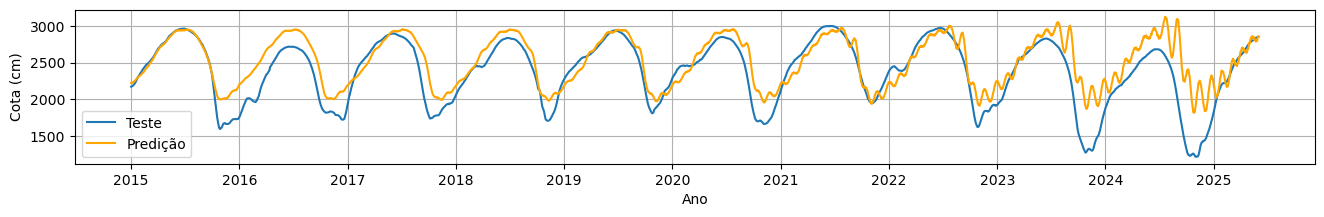

In [7]:
print(f"R² = {r2_score(teste['14990000'], best_y_pred):.4f}")
print(f"MSE = {mean_squared_error(teste['14990000'], best_y_pred):.4f}")
print(f"RMSE = {root_mean_squared_error(teste['14990000'], best_y_pred):.4f}")
print(f"MAE = {mean_absolute_error(teste['14990000'], best_y_pred):.4f}")

plt.figure(figsize=(16, 2))
plt.plot(teste['14990000'], label='Teste')
plt.plot(best_y_pred, label='Predição', color='orange')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.legend()
plt.show()

#### Random Forest

In [8]:
rf = RandomForestRegressor(n_jobs=-1)

In [10]:
rf.fit(x_shifts.iloc[window_length:], treino['14990000'][window_length:])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
test_predictions = []
first_eval_batch = treino['14990000'][-window_length:].values
current_batch = first_eval_batch.reshape((1, window_length))

for i in range(len(teste)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = rf.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)

R² = 0.6277
MSE = 70561.9571
RMSE = 265.6350
MAE = 187.2919


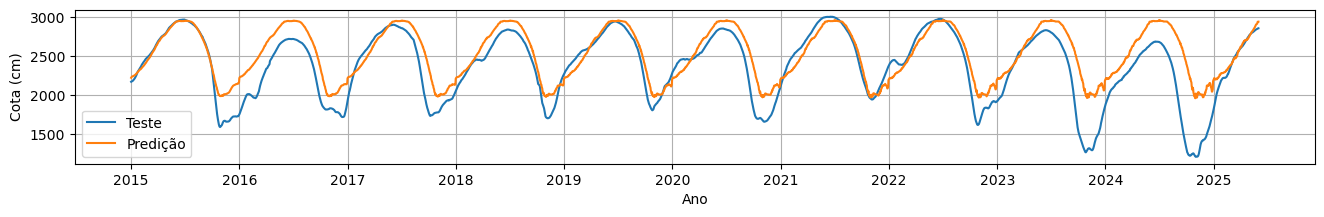

In [29]:
y_pred = pd.DataFrame(test_predictions)
y_pred.index = teste['14990000'].index

print(f"R² = {r2_score(teste['14990000'], y_pred):.4f}")
print(f"MSE = {mean_squared_error(teste['14990000'], y_pred):.4f}")
print(f"RMSE = {root_mean_squared_error(teste['14990000'], y_pred):.4f}")
print(f"MAE = {mean_absolute_error(teste['14990000'], y_pred):.4f}")

plt.figure(figsize=(16, 2))
plt.plot(teste['14990000'], label='Teste')
plt.plot(y_pred, label='Predição')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.legend()
plt.show()

##### SVR

In [32]:
svr = SVR()

svr.fit(x_shifts.iloc[window_length:], treino['14990000'][window_length:])

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [33]:
test_predictions = []
first_eval_batch = treino['14990000'][-window_length:].values
current_batch = first_eval_batch.reshape((1, window_length))

for i in range(len(teste)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = svr.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)

R² = 0.5088
MSE = 93098.3680
RMSE = 305.1203
MAE = 223.8508


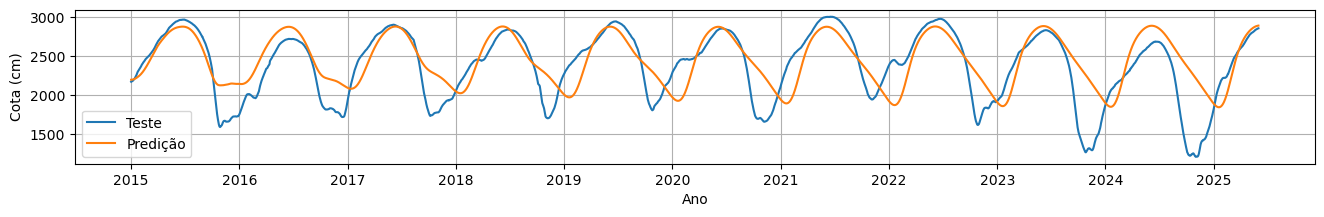

In [34]:
y_pred = pd.DataFrame(test_predictions)
y_pred.index = teste['14990000'].index

print(f"R² = {r2_score(teste['14990000'], y_pred):.4f}")
print(f"MSE = {mean_squared_error(teste['14990000'], y_pred):.4f}")
print(f"RMSE = {root_mean_squared_error(teste['14990000'], y_pred):.4f}")
print(f"MAE = {mean_absolute_error(teste['14990000'], y_pred):.4f}")

plt.figure(figsize=(16, 2))
plt.plot(teste['14990000'], label='Teste')
plt.plot(y_pred, label='Predição')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.legend()
plt.show()

### Teste 2

Prever cota da estação jusante usando as cotas das estações montantes

In [15]:
path = 'Cotas extraidas'
arquivos = [
    'dados_diarios_estacao_14110000.csv',
    # 'dados_diarios_estacao_14300000.csv',
    'dados_diarios_estacao_14420000.csv',
    'dados_diarios_estacao_14480002.csv',
    'dados_diarios_estacao_14840000.csv',
    'dados_diarios_estacao_14990000.csv'
]
dados = eda.data_processing(path, '1985-01-01', '2023-12-31', arquivos)
dados

,14110000,14420000,14480002,14840000,14990000
Data,,,,,
1985-01-01,1766.0,737.0,409.0,669.0,2169.0
1985-01-02,1771.0,760.0,411.0,677.0,2178.0
1985-01-03,1774.0,769.0,413.0,681.0,2186.0
1985-01-04,1773.0,783.0,416.0,685.0,2194.0
1985-01-05,1769.0,788.0,427.0,691.0,2201.0
...,...,...,...,...,...
2023-12-27,1480.0,607.0,325.0,413.0,1807.0
2023-12-28,1485.0,603.0,329.0,421.0,1822.0
2023-12-29,1492.0,601.0,331.0,427.0,1834.0


In [16]:
dados_dessazonalizados = dados.copy()

for c in dados.columns:
    decompostion = seasonal_decompose(dados[c], model='additive', period=365)
    seasonal = decompostion.seasonal
    deseasonalized_data = dados[c] - seasonal
    dados_dessazonalizados[c] = dados[c] - seasonal

    # plt.figure(figsize=(12, 8))
    # plt.subplot(311)
    # plt.plot(dados[c], label='Original')
    # plt.legend(loc='upper left')
    # plt.subplot(312)
    # plt.plot(seasonal, label='Seasonality')
    # plt.legend(loc='upper left')
    # plt.subplot(313)
    # plt.plot(deseasonalized_data, label='Deseasonalized')
    # plt.legend(loc='upper left')
    # plt.suptitle(c)
    # plt.tight_layout()
    # plt.show()

In [17]:
dados_dessazonalizados

,14110000,14420000,14480002,14840000,14990000
Data,,,,,
1985-01-01,1941.113935,861.801943,593.158599,1022.390214,2502.926768
1985-01-02,1949.296847,881.481611,594.581527,1026.845585,2506.835348
1985-01-03,1954.848109,894.581972,596.004526,1027.774424,2509.243783
1985-01-04,1955.030445,906.050753,598.638123,1028.203119,2511.099587
1985-01-05,1953.081058,911.256233,609.087511,1030.842196,2512.350056
...,...,...,...,...,...
2023-12-27,1664.081058,730.256233,507.087511,752.842196,2118.350056
2023-12-28,1670.895117,725.382765,510.878787,757.165412,2127.100452
2023-12-29,1682.130373,723.667336,512.722839,759.725325,2132.982355


In [18]:
tgt = '14990000'

for c in dados_dessazonalizados.columns:
    if c == tgt:
        continue
    best_lag = None
    max_corr = -np.inf

    for i in range(32):
        corr = dados_dessazonalizados[tgt].corr(dados_dessazonalizados[c].shift(i), method='spearman')

        if corr > max_corr:
            max_corr = corr
            best_lag = i
    
    print(f"Estação {c}: Melhor lag = {best_lag}; Correlação = {max_corr:.4f}")

Estação 14110000: Melhor lag = 23; Correlação = 0.4750
Estação 14420000: Melhor lag = 19; Correlação = 0.6140
Estação 14480002: Melhor lag = 12; Correlação = 0.7488
Estação 14840000: Melhor lag = 4; Correlação = 0.8751


In [19]:
x_shifts = {
    # '14300000_lag-28': dados['14300000'].shift(28),
    # '14110000_lag-23': dados['14110000'].shift(23),
    # '14420000_lag-19': dados['14420000'].shift(19),
    '14480002_lag-12': dados['14480002'].shift(12),
    '14840000_lag-4': dados['14840000'].shift(4)
}

x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)
x_shifts

,14480002_lag-12,14840000_lag-4
Data,,
1985-01-01,0.0,0.0
1985-01-02,0.0,0.0
1985-01-03,0.0,0.0
1985-01-04,0.0,0.0
1985-01-05,0.0,669.0
...,...,...
2023-12-27,253.0,374.0
2023-12-28,259.0,388.0
2023-12-29,265.0,396.0


In [20]:
x_train, y_train = x_shifts['1986-01-01':'2014-12-31'], dados['14990000']['1986-01-01':'2014-12-31']
x_test, y_test = x_shifts['2015-01-01':], dados['14990000']['2015-01-01':]

In [21]:
def results(y_test, y_pred):
    print(f"R²: {r2_score(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

    plt.figure(figsize=(16, 2))
    plt.plot(y_test, label='Teste')
    plt.plot(y_pred, label='Predição')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.xlabel('Ano')
    plt.ylabel('Cota (cm)')
    plt.legend()
    plt.show()

In [22]:
hidden_layers = [(5, 5), (10, 10), (10, 5), (20, 10), (30, 30), (30, 15), (25, 15)]
f_activation = ['relu', 'identity']
solvers = ['adam']
epochs = [2000, 3000, 4000]

grid = list(product(hidden_layers, f_activation, solvers, epochs))

In [23]:
def train_iter(x_train, y_train, x_test, y_test, arch):
    mlp = MLPRegressor(
        hidden_layer_sizes=arch[0],
        activation=arch[1],
        solver=arch[2],
        max_iter=arch[3],
        early_stopping=True,
        n_iter_no_change=50,
        verbose=False
    )
    mlp.fit(x_train, y_train)

    test_predictions = mlp.predict(x_test)
    y_pred = pd.DataFrame(test_predictions, index=y_test.index)

    r2 = r2_score(y_test, y_pred)

    return r2, y_pred, mlp

In [24]:
# Executa em paralelo
resultados_detalhados = []

for i, model in enumerate(grid):
    print(f"Modelo {i+1}/{len(grid)}: {model}")
    resultados = Parallel(n_jobs=-1)(
        delayed(train_iter)(x_train, y_train, x_test, y_test, model) for _ in range(100)
    )

    # Seleciona o melhor resultado
    best_r2, best_y_pred, best_mlp = max(resultados, key=lambda x: x[0])
    r2s = [r2[0] for r2 in resultados]
    r2_mean = np.mean(r2s)
    r2_std = np.std(r2s)

    resultados_detalhados.append({
        'modelo': model,
        'best_r2': best_r2,
        'r2_mean': r2_mean,
        'r2_std': r2_std,
        'best_pred': best_y_pred
    })

Modelo 1/42: ((5, 5), 'relu', 'adam', 2000)


/home/dsantos/miniforge3/envs/ml_sklearn/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Modelo 2/42: ((5, 5), 'relu', 'adam', 3000)
Modelo 3/42: ((5, 5), 'relu', 'adam', 4000)


/home/dsantos/miniforge3/envs/ml_sklearn/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


Modelo 4/42: ((5, 5), 'identity', 'adam', 2000)
Modelo 5/42: ((5, 5), 'identity', 'adam', 3000)
Modelo 6/42: ((5, 5), 'identity', 'adam', 4000)
Modelo 7/42: ((10, 10), 'relu', 'adam', 2000)
Modelo 8/42: ((10, 10), 'relu', 'adam', 3000)
Modelo 9/42: ((10, 10), 'relu', 'adam', 4000)
Modelo 10/42: ((10, 10), 'identity', 'adam', 2000)
Modelo 11/42: ((10, 10), 'identity', 'adam', 3000)
Modelo 12/42: ((10, 10), 'identity', 'adam', 4000)
Modelo 13/42: ((10, 5), 'relu', 'adam', 2000)
Modelo 14/42: ((10, 5), 'relu', 'adam', 3000)
Modelo 15/42: ((10, 5), 'relu', 'adam', 4000)
Modelo 16/42: ((10, 5), 'identity', 'adam', 2000)
Modelo 17/42: ((10, 5), 'identity', 'adam', 3000)
Modelo 18/42: ((10, 5), 'identity', 'adam', 4000)
Modelo 19/42: ((20, 10), 'relu', 'adam', 2000)
Modelo 20/42: ((20, 10), 'relu', 'adam', 3000)
Modelo 21/42: ((20, 10), 'relu', 'adam', 4000)
Modelo 22/42: ((20, 10), 'identity', 'adam', 2000)
Modelo 23/42: ((20, 10), 'identity', 'adam', 3000)
Modelo 24/42: ((20, 10), 'identity

In [8]:
# mlp = MLPRegressor(
#     hidden_layer_sizes=(30, 30),
#     activation='relu',
#     max_iter=4000,
#     early_stopping=True,
#     n_iter_no_change=50,
#     shuffle=False
# )

# mlp.fit(x_train, y_train)

# test_predictions = mlp.predict(x_test)
# y_pred = pd.DataFrame(test_predictions, index=y_test.index)

In [25]:
resultados_df = pd.DataFrame(resultados_detalhados)
resultados_df.loc[resultados_df.r2_mean.idxmax()]

modelo                        ((25, 15), identity, adam, 2000)
best_r2                                               0.923461
r2_mean                                               0.920227
r2_std                                                0.001292
best_pred                          0
Data                  ...
Name: 39, dtype: object

In [26]:
best_y_pred = resultados_df['best_pred'].loc[resultados_df.r2_mean.idxmax()]
best_y_pred

,0
Data,
2015-01-01,2024.198960
2015-01-02,2025.333071
2015-01-03,2026.467182
2015-01-04,2026.467182
2015-01-05,2024.687433
...,...
2023-12-27,1684.700081
2023-12-28,1702.811901
2023-12-29,1710.245228


R²: 0.9235
MSE: 13567.8948
RMSE: 116.4813
MAE: 87.2133


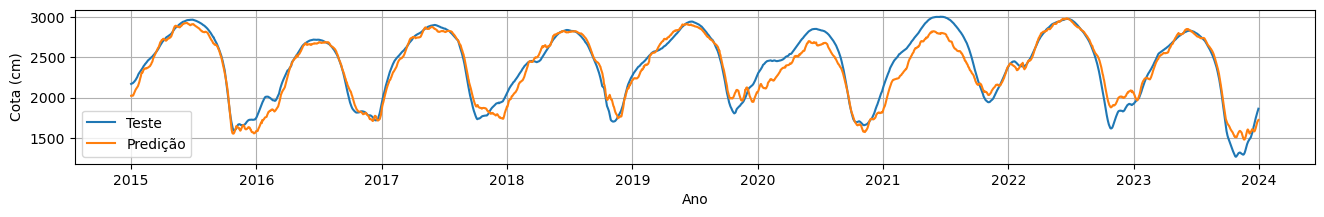

In [27]:
results(y_test, best_y_pred)

### Teste 3
Usando cotas montantes + anomalias de El Niño para prever a cota jusante

In [51]:
path = 'Cotas extraidas'
arquivos = [
    'dados_diarios_estacao_14480002.csv',
    'dados_diarios_estacao_14840000.csv',
    'dados_diarios_estacao_14990000.csv'
]

dados2 = eda.data_processing(path, '1985-01-01', '2020-12-31', arquivos)
dados2

,14480002,14840000,14990000
Data,,,
1985-01-01,409.0,669.0,2169.0
1985-01-02,411.0,677.0,2178.0
1985-01-03,413.0,681.0,2186.0
1985-01-04,416.0,685.0,2194.0
1985-01-05,427.0,691.0,2201.0
...,...,...,...
2020-12-27,477.0,589.0,2062.0
2020-12-28,480.0,597.0,2072.0
2020-12-29,482.0,603.0,2080.0


In [52]:
nino3 = pd.read_csv('El Nino - indices/sst_nino3.csv', sep=';')
nino34 = pd.read_csv('El Nino - indices/sst_nino34.csv', sep=';')

In [53]:
nino3['time'] = pd.to_datetime(nino3['time'])
nino3.index = nino3['time']
nino3.drop(columns=['time'], inplace=True)

nino34['time'] = pd.to_datetime(nino34['time'])
nino34.index = nino34['time']
nino34.drop(columns=['time'], inplace=True)

In [54]:
dados2['El Nino 3'] = nino3['sst']
dados2['El nino 34'] = nino34['sst']
dados2

,14480002,14840000,14990000,El Nino 3,El nino 34
Data,,,,,
1985-01-01,409.0,669.0,2169.0,-1.130554,-1.003260
1985-01-02,411.0,677.0,2178.0,-1.118706,-0.972396
1985-01-03,413.0,681.0,2186.0,-1.004945,-0.960776
1985-01-04,416.0,685.0,2194.0,-0.933292,-0.977119
1985-01-05,427.0,691.0,2201.0,-0.936055,-1.000219
...,...,...,...,...,...
2020-12-27,477.0,589.0,2062.0,-0.695351,-0.900767
2020-12-28,480.0,597.0,2072.0,-0.639939,-0.881045
2020-12-29,482.0,603.0,2080.0,-0.601540,-0.874717


In [55]:
x_shifts = {
    'El Nino34_lag-190': dados2['El nino 34'].shift(190),
    'El Nino 3_lag-178': dados2['El Nino 3'].shift(178),
    '14480002_lag-12': dados2['14480002'].shift(12),
    '14840000_lag-4': dados2['14840000'].shift(4)
}

x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)
x_shifts

,El Nino34_lag-190,El Nino 3_lag-178,14480002_lag-12,14840000_lag-4
Data,,,,
1985-01-01,0.000000,0.000000,0.0,0.0
1985-01-02,0.000000,0.000000,0.0,0.0
1985-01-03,0.000000,0.000000,0.0,0.0
1985-01-04,0.000000,0.000000,0.0,0.0
1985-01-05,0.000000,0.000000,0.0,669.0
...,...,...,...,...
2020-12-27,-0.373382,-0.367293,461.0,580.0
2020-12-28,-0.350001,-0.320890,463.0,582.0
2020-12-29,-0.255234,-0.312356,465.0,582.0


In [56]:
x_train, y_train = x_shifts['1986-01-01':'2014-12-31'], dados2['14990000']['1986-01-01':'2014-12-31']
x_test, y_test = x_shifts['2015-01-01':], dados2['14990000']['2015-01-01':]

In [66]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape((-1,1)))

In [70]:
mlp = MLPRegressor(
    hidden_layer_sizes=(30, 30),
    activation='relu',
    max_iter=4000,
    early_stopping=True,
    n_iter_no_change=50,
    shuffle=False
)

mlp.fit(x_train_scaled, y_train_scaled)

test_predictions = mlp.predict(x_test_scaled)
y_pred = pd.DataFrame(test_predictions, index=y_test.index)

In [71]:
y_pred_inv = y_scaler.inverse_transform(y_pred)

In [72]:
y_pred_inv

array([[2194.11019157],
       [2194.55370419],
       [2187.03597787],
       ...,
       [1869.12571438],
       [1876.39099692],
       [1878.4178272 ]], shape=(2192, 1))

In [74]:
y_pred_df = pd.DataFrame(y_pred_inv, index=y_test.index)

R²: 0.9498
MSE: 7926.5450
RMSE: 89.0311
MAE: 62.1414


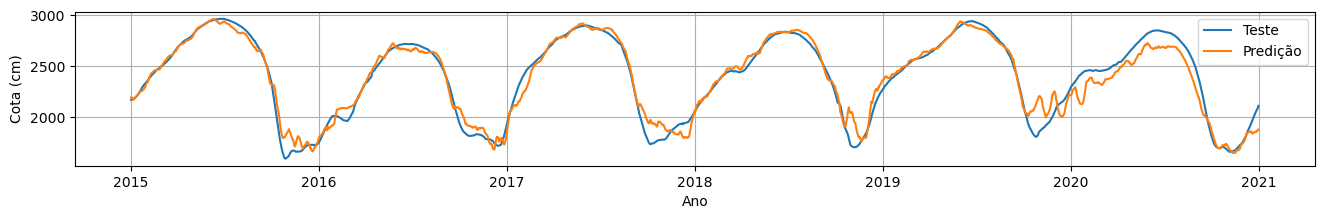

In [75]:
results(y_test, y_pred_df)